In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import f1_score, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score, roc_curve
from tqdm import tqdm

In [4]:
data = pd.read_pickle("./data.pkl")

# split data into X and y
X = data.loc[:, data.columns != 'bot']
Y = data.loc[:, data.columns == 'bot'].to_numpy()

# split data into train and test sets
seed = 10
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [5]:
# Labels for this algortihm has to be either 1 or -1
y_train = np.where(y_train < 0.5, -1, 1)
y_test = np.where(y_test < 0.5, -1, 1)

y_train = y_train.flatten()
y_test = y_test.flatten()

# Custom implementation of AdaBoost algorithm


In [25]:
class ourAdaboostClassifier:
    def __init__(self, x=None,y=None, n_iterations = 100):
        self.number_iterations = n_iterations
    
    def fit(self,X_train,y_train):
        number_samples = np.shape(X_train)[0]
        weights = np.ones(number_samples)/number_samples
        
        # There will be as many weak learners as iterations
        self.weak_learners = np.zeros(shape=self.number_iterations, dtype=object)
        self.significance_vec = np.zeros(shape=self.number_iterations)
        error_vec = []
        accuracy_vec = []
        
        for iterations in range(self.number_iterations):
            current_weights = weights

            weak_learner = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
            weak_learner_model = weak_learner.fit(X_train, y_train, sample_weight=current_weights)

            # The new weak learner model is saved
            self.weak_learners[iterations] = weak_learner_model
            weak_learner_pred = weak_learner_model.predict(X_train)

            error = 0
            incorrect_pred = 0
            correct_pred = 0
            for item_index in range(number_samples):
                if weak_learner_pred[item_index] != y_train[item_index]:
                    incorrect_pred = incorrect_pred + 1
                    error = error + current_weights[item_index]
                else: 
                    correct_pred = correct_pred + 1 

            # Save error for plotting    
            # error_vec.append(error)

            # Significance of the weak learner model is calculated and saved
            significance = 0.5*np.log((1-error)/error) 
            self.significance_vec[iterations] = significance

            # Update weights for each sample
            for item_index in range(number_samples):
                if weak_learner_pred[item_index] != y_train[item_index]:
                    weights[item_index] = np.multiply(current_weights[item_index],np.exp(significance))
                else:
                    weights[item_index] = current_weights[item_index]*np.exp(-significance)

            # Normalize weights
            weights /= weights.sum()
        
    def predict(self,X_test):
        model_preds = np.array([model.predict(X_test) for model in self.weak_learners])
        y_test_pred = np.sign(np.dot(self.significance_vec, model_preds))
        return y_test_pred.astype(int)

In [48]:
class AdaCost:
    """This is the implementation of the AdaCost Classifier. In this algorithm, 
    the weight update is modified by adding a cost adjustment function φ. 
    This function, for an instance with a higher cost factor increases its weight 
    “more” if the instance is misclassified, but decreases its weight “less” otherwise.
    
    This implementation uses the function φ = +/-0.5*cost + 0.5
    
    Requires:
        X_train: Training features. Size N x D
        y_train: Training labels. Size N x 1
        cost: cost used to update weight via the adjustment function

    """
    
    def __init__(self, x=None,y=None, n_iterations = 100):
        self.number_iterations = n_iterations
        
    def fit(self,X_train,y_train, cost):
        # Initialize weights
        number_samples = len(X_train)
        weights = np.ones(number_samples)/number_samples
        
        # Define adjustment function φ (called beta)
        beta = 0.5*np.ones(number_samples)
        beta[np.where(y_train==1)[0]] += cost*0.5
        beta[np.where(y_train==-1)[0]] -= cost*0.5
        
        # Define vectors to store weak predictors and significances of each iteration
        self.weak_learners = np.zeros(shape=self.number_iterations, dtype=object)
        self.significance_vec = np.zeros(shape=self.number_iterations)
        
        for it in range(self.number_iterations):
            current_weights = weights
            
            # Create and save week learner for this iteration
            weak_learner_model = DecisionTreeClassifier(max_depth=1, 
                                 max_leaf_nodes=2).fit(X_train, y_train, sample_weight=current_weights)
            self.weak_learners[it] = weak_learner_model
            weak_learner_pred = weak_learner_model.predict(X_train)
            
            # Calculate r
            u = np.multiply(np.multiply(weak_learner_pred, y_train),beta)
            r = np.sum(np.multiply(weights,u))
            
            # Calculate and store significance of this iteration
            significance = 0.5 * np.log((1+r)/(1-r))
            self.significance_vec[it] = significance
            
            # Update weights for next iteration
            weights = np.multiply(weights,np.exp(-significance * u))
            weights /= weights.sum()    
            
            # Round Debugging
            #print('Round %d' % (it))
            #print(u)
            #print(r)
            #print(significance)
            #print(weights)
            
            #input()
        
    def predict(self,X_test):
        model_preds = np.array([model.predict(X_test) for model in self.weak_learners])
        y_test_pred = np.sign(np.dot(self.significance_vec, model_preds))
        return y_test_pred.astype(int)

## Testing

In [49]:
#classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=100)
#classifier.fit(X_train, y_train)
#predictions = classifier.predict(X_test)

#ourClassifier = ourAdaboostClassifier()
AdaCostClassifier = AdaCost()

#ourClassifier.fit(X_train, y_train)
AdaCostClassifier.fit(X_train, y_train,cost = 0.5)

#ourpredictions = ourClassifier.predict(X_test)
ourAdaCostpred = AdaCostClassifier.predict(X_test)
print('Accuracy with default Adaboost: %.4f' % (len(np.where(y_test==predictions)[0])/len(y_test)))
print('Accuracy with our Adaboost:     %.4f' % (len(np.where(y_test==ourpredictions)[0])/len(y_test)))
print('Accuracy with AdaCost:          %.4f' % (len(np.where(y_test==ourAdaCostpred)[0])/len(y_test)))


Accuracy with default Adaboost: 0.8572
Accuracy with our Adaboost:     0.8455
Accuracy with AdaCost:          0.7973


In [50]:
### Finding the best cost fit

In [51]:
ourCostClassifier = AdaCost()
accuracy = []
costs = np.linspace(-0.5,0.5,11)
for c in tqdm(costs):
    ourCostClassifier.fit(X_train, y_train,cost = c)
    ourCostpredictions = ourCostClassifier.predict(X_test)
    accuracy.append(len(np.where(y_test==ourCostpredictions)[0])/len(y_test))


100%|██████████| 11/11 [02:51<00:00, 15.60s/it]


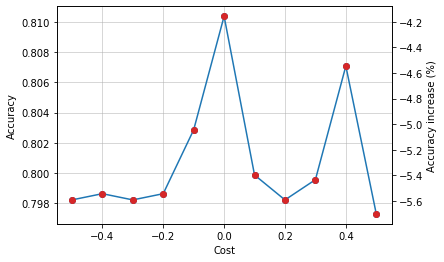

In [52]:
# Plot Accuracy vs. Cost
base_acc = (len(np.where(y_test==ourpredictions)[0])/len(y_test))

plt.figure()
ax1 = plt.subplot(111)
plt.grid(True,which='major',linewidth=0.5)
plt.grid(True,which='minor',linewidth=0.1)
plt.plot(costs, accuracy,'-o')
plt.xlabel('Cost')
plt.ylabel('Accuracy')

ax2 = ax1.twinx()
plt.plot(costs,(np.array(accuracy)-base_acc)/base_acc*100,'o',color='tab:red')
ax2.set_ylabel('Accuracy increase (%)')
plt.show()

### Draft

In [29]:
number_iterations = 100

number_samples = np.shape(X_train)[0]

weights = np.ones(number_samples)/number_samples

# There will be as many weak learners as iterations
weak_learners = np.zeros(shape=number_iterations, dtype=object)

significance_vec = np.zeros(shape=number_iterations)

error_vec = []
accuracy_vec = []

for iterations in range(number_iterations):
    
    current_weights = weights
    
    weak_learner = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
    weak_learner_model = weak_learner.fit(X_train, y_train, sample_weight=current_weights)
    
    
    # The new weak learner model is saved
    weak_learners[iterations] = weak_learner_model
    
    weak_learner_pred = weak_learner_model.predict(X_train)
    
    error = 0
    incorrect_pred = 0
    correct_pred = 0
    
    for item_index in range(number_samples):

        if weak_learner_pred[item_index] != y_train[item_index]:
            incorrect_pred = incorrect_pred + 1
            error = error + current_weights[item_index]
        else: 
            correct_pred = correct_pred + 1 
            
    # Save error for plotting    
    error_vec.append(error)
    
    # Significance of the weak learner model is calculated and saved
   
    significance = 0.5*np.log((1-error)/error) 
        
    significance_vec[iterations] = significance

    #########################
    
    # Update weights for each sample
    
    for item_index in range(number_samples):
        if weak_learner_pred[item_index] != y_train[item_index]:

            weights[item_index] = np.multiply(current_weights[item_index],np.exp(significance))

        else:
            weights[item_index] = current_weights[item_index]*np.exp(-significance)
     
    # Alternative
    # weights = current_weights * np.exp(-significance*  y_train * weak_learner_pred)
    

    #########################
    
    # Normalize weights
    
    weights /= weights.sum()

    
    
    

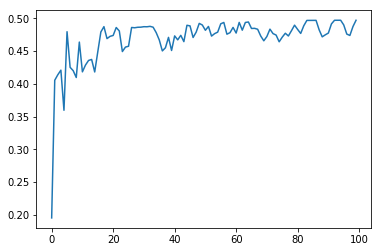

In [30]:
plt.plot(error_vec)
plt.show()

In [31]:
# Get prediction of each weak learner 
model_preds = np.array([model.predict(X_test) for model in weak_learners])
y_test_pred = np.sign(np.dot(significance_vec, model_preds))

In [32]:
# Calculate accuracy 

correct_pred = 0

for item_index in range(np.shape(y_test_pred)[0]):

        if y_test_pred[item_index] == y_test[item_index]:

            correct_pred = correct_pred + 1 
            
print("Accuracy custom implementation = " + str(correct_pred/np.shape(y_test_pred)[0]))

Accuracy custom implementation = 0.845513413506013


In [33]:
f1_score = f1_score(y_test, y_test_pred.astype(int), average='weighted')
print("F1 Score Adaboost: " + str(f1_score))

F1 Score Adaboost: 0.8414968326746479


# Sklearn implementation of AdaBoost Algorithm


In [34]:
classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=100)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

In [35]:
# Calculate accuracy 

correct_pred = 0

for item_index in range(np.shape(predictions)[0]):

        if predictions[item_index] == y_test[item_index]:

            correct_pred = correct_pred + 1 
            
print("Accuracy sklearn implementation = " + str(correct_pred/np.shape(y_test_pred)[0]))

Accuracy sklearn implementation = 0.8572309589885908


In [45]:
f1_score = f1_score(y_test, predictions, average='weighted')
print("F1 Score Adaboost: " + str(f1_score))

TypeError: 'numpy.float64' object is not callable